<a href="https://colab.research.google.com/github/anaapbernardo/Bootcamp_DataScience/blob/main/Ana_Bernardo_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author: Ana Paula da Silva Bernardo*

[LinkedIn](https://www.linkedin.com/in/ana-paula-sbernardo/)

[GitHub](https://github.com/anaapbernardo)

# Summary

This project is an analysis of COVID-19 cases of the Sírio-Libanês hospital.

The dataset used and all the information presented on this notebook was made available by the Sírio-Libanês hospital at [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19)

# Introduction

COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources. 

Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20. Now*, more than one year after the first case, Brazil have 13,100,580 confirmed cases of COVID-19 with 336,947 deaths, reported to [World Health Organization (8 April, 2021)](https://covid19.who.int/region/amro/country/br).

There is urgency in obtaining accurate data to better prepare healthcare systems and avoid their collapse (figure below). One way of doing this is through the use of individual clinical data to create a machine learning model to predict if the patient will need or not an ICU bed.

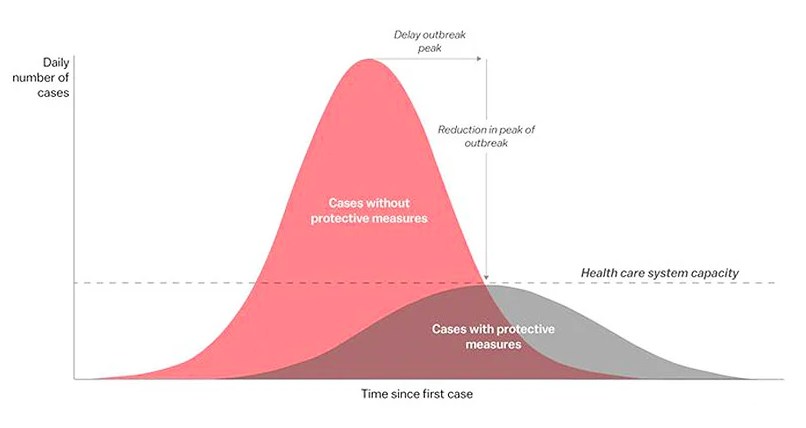

Therefore, the aim of this project is to use a machine learning model to predict admission to the ICU of confirmed COVID-19 cases, providing accurate information to hospitals, so ICU resources can be arranged or patient transfer can be scheduled.

# Preliminary Analysis

## Initial Procedures

### Importing libraries

Pandas Profiling* and Pycaret libraries are commented on here because they demand to be installed and consume much time to run. So, the important results are available as a screenshot in this notebook.

In [ ]:
#! pip install -U pandas_profiling

#from pandas_profiling import ProfileReport
#from pandas_profiling.utils.cache import cache_file

In [ ]:
#! pip install pycaret

#from pycaret.utils import enable_colab 
#enable_colab()

#from pycaret.classification import setup
#from pycaret.classification import compare_models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### Dataset URL

In [ ]:
hospital_sirio_libanes_dataset = 'https://github.com/anaapbernardo/Bootcamp_DataScience/blob/main/Files%20-%20Bootcamp%20Data%20Science/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

### Functions

In [ ]:
# Removing data of patients that went directly to ICU

def remove_not_usable_data(df_original):
  
    to_remove = df_original.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
    df_usable = df_original.query('PATIENT_VISIT_IDENTIFIER not in @to_remove')

    return df_usable

In [ ]:
# Finding patients that went to ICU in any Window and add number 1 in Window 0-2

def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

In [ ]:
# Filling NaN values

def fill_table(df_organize):

    # Selecting continuos features
    cont_features_columns = df_organize.iloc[:, 13:-2].columns
    cont_features = df_organize.groupby('PATIENT_VISIT_IDENTIFIER', 
                            as_index=False)[cont_features_columns]

    # Filling NaN values with foward fill
    cont_features = cont_features.fillna(method='ffill')

    # Filling other NaN values with median
    median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    cont_features = median_imputer.fit_transform(cont_features)
    cont_features = pd.DataFrame(data=cont_features, columns=cont_features_columns)
    
    # Selecting category features
    cat_features = df_organize.iloc[:, :13]
    
    # Selecting other features
    other_features = df_organize.iloc[:, -2:]
    
    # Concatenating features
    df_fill = pd.concat([cat_features, cont_features, other_features], axis=1)
    df_fill.columns = df_organize.columns

    return df_fill

In [ ]:
# Create a table for demographic analysis

def create_table_exp_analysis(df: pd.DataFrame, column1: str, column2: str):

    # Select columns
    table = df[[column1, column2]]

    # Separate ICU and NO_ICU groups
    total_patients = table.groupby([column1]).count()
    icu_patients = table.groupby([column1]).sum()
    no_icu_patients = total_patients - icu_patients

    # Merge and organize the new table
    info_vs_icu = icu_patients.merge(no_icu_patients, how='inner', on=column1)
    info_vs_icu.rename(columns={'ICU_x': 'ICU', 'ICU_y': 'NO_ICU'}, inplace=True)
    info_vs_icu.reset_index(inplace=True)

    # Add % columns
    sum = info_vs_icu['ICU'] + info_vs_icu['NO_ICU']
    for i in sum:
      info_vs_icu['%ICU'] = info_vs_icu['ICU']/sum*100
      info_vs_icu['%NO_ICU'] = info_vs_icu['NO_ICU']/sum*100

    return info_vs_icu

In [ ]:
# Create plot for demographic analysis

def create_plot_exp_analysis(N: int, df: pd.DataFrame, title: str, 
                            xlabel: str, tick_labels: list):
  
    # Variables
    N = N
    ind = np.arange(N)
    bar_width = 0.3

    plt.figure(figsize=(12, 8))

    # Bar plots
    plt.bar(x=ind, height='ICU', data=df, 
            edgecolor='black', width = bar_width, label='Admitted to ICU')
    plt.bar(x=ind + bar_width, height='NO_ICU', data=df, 
            edgecolor='black', width = bar_width, label='Not admitted to ICU')

    # Parameters
    plt.legend()
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel('Number of Patients', fontsize=14, fontweight='bold')
    plt.xticks(ind + bar_width / 2, tick_labels, fontsize=12)
    plt.yticks(fontsize=12)

    return plt.show()

In [ ]:
# Remove highly correlated data

def remove_high_correlation(data: pd.DataFrame, high_corr: float):

    # Create correlation matrix
    matrix_corr = data.iloc[:, 4:-1].corr().abs()

    # Create a boolean upper matrix
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), 
                                             k=1).astype(np.bool))
    
    # Delete highly correlated data
    delete = [column for column in matrix_upper.columns 
              if any(matrix_upper[column] > high_corr)]

    return data.drop(delete, axis=1)

In [ ]:
# Run Machine Learning Model and Print AUC score

def run_model_auc_score(ml_model, data: pd.DataFrame, 
                        n_splits: int, n_repeats: int):

    # Separate the dataset into data to be evaluated (x) and the target data (y)
    np.random.seed(1231234)
    data = data.sample(frac=1).reset_index(drop=True)
    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']
    
    # Use Repeated Stratified KFold and Cross-Validation to split the data into train and test
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    results = cross_validate(ml_model, x, y, cv=cv, scoring='roc_auc')
    
    # Calcute the AUC mean and standard deviation (evaluation metrics)
    auc_mean = np.mean(results['test_score'])
    auc_std = np.std(results['test_score'])
    
    print(f' AUC: {auc_mean:.4f}'
          f'\n Confidence Interval: {auc_mean-(2*auc_std):.4f} - {auc_mean+(2*auc_std):.4f}')

    return auc_mean

In [ ]:
# Validation matrics 

def validation_metrics(data: pd.DataFrame, ml_model):

    # Separate the dataset into data to be evaluated (x) and the target data (y)
    np.random.seed(1231234)
    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']

    # Split the dataset into test and train
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    # Train the model and create a report
    ml_model.fit(x_train, y_train)
    prediction = ml_model.predict(x_test)
    report = print(classification_report(y_test, prediction))

    # Plot confusion matrix
    matrix = plot_confusion_matrix(ml_model, x_test, y_test, 
                                   display_labels=['No ICU', 'ICU'])
    
    return report, matrix

In [ ]:
# Feature Selection

def rfe_feature_selection_and_new_df(data: pd.DataFrame):

    # Separate the dataset into data to be evaluated (x) and the target data (y)
    np.random.seed(1231234)
    x_columns = data.columns
    x = data[x_columns].drop(['ICU'], axis=1)
    y = data['ICU']

    # Feature Selection using RFE
    estimator_lr = LogisticRegression(max_iter=1000)
    rfe = RFE(estimator_lr)
    fit = rfe.fit(x, y)

    # Create a new dataframe with the features selected
    columns = fit.get_support(indices=True)
    new_df = data.iloc[:, columns]
    column_icu = data['ICU']
    new_df = new_df.join(column_icu)

    return new_df

## Data Cleaning

In [ ]:
df = pd.read_excel(hospital_sirio_libanes_dataset)
df

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

Sírio-Libanês instructions:
- Do not use data when the patient is admitted to the ICU (see figure bellow)
- Use the data collected on the first window (0-2), as early identification is key for appropriate treatment.

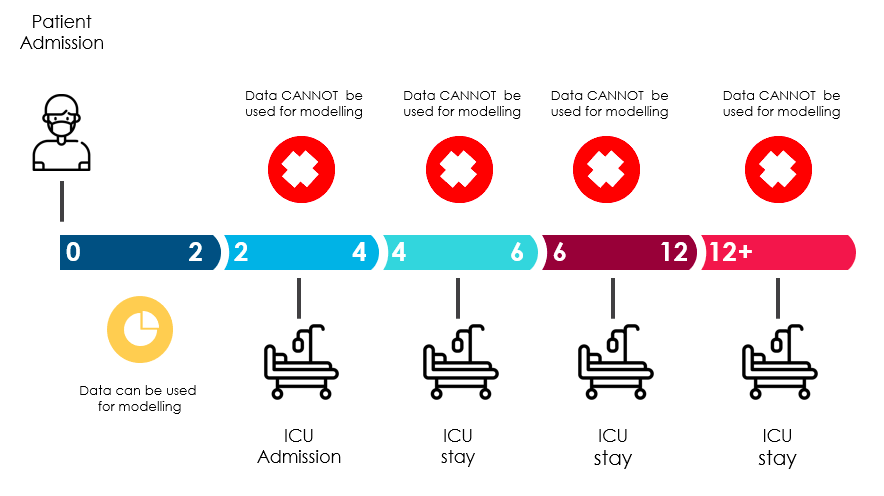

I followed these steps to clean and organize the dataset:
1. Remove the data from patients that went to ICU in the first window 0-2 (32 patients)
2. If the patient went to ICU in any other window, add the number 1 in the column ICU on the row of window 0-2, then removed all other rows from each patient.
3. Reset index and set age percentil as category
4. Then, after removing all unnecessary data and organizing the dataframe, fill the NaN numbers with forward fill and SimpleImputer
5. Finally, dropped any remaining NaN values

In [ ]:
#Remove patients that went direct to the ICU
df_clean = remove_not_usable_data(df)

#If the patient went to the ICU, add 1 at ICU column in the row of Window 0-2
df_clean = df_clean.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

# Reset index and set Age Percentil as category
df_clean.reset_index(drop=True, inplace=True)
df_clean['AGE_PERCENTIL'] = df_clean['AGE_PERCENTIL'].astype('category').cat.codes

# Fill NaN values
df_clean = fill_table(df_clean)

# Drop remaining NaN values
df_clean = df_clean.dropna()

df_clean

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.00000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
4,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,..

# Exploratory Analysis

## Frequency of ICU admission in each window

Evaluating the frequency of ICU admission, the first thing that I noticed was that when a patient is admitted to the ICU, the following rows of the same patient are also filled with 1 (ICU column). Therefore, the total number of patients admitted to the ICU is the sum of ICU admission in the last window (above 12). Also, to calculated the number of ICU admission per window I subtracted the number of ICU admission of the window before.

In [ ]:
# Total number of ICU admission
icu_total = df.query('WINDOW=="ABOVE_12" and ICU==1')['ICU'].sum()

print(f'The total number of patients admitted to the ICU were: {icu_total}')

The total number of patients admitted to the ICU were: 195


In [ ]:
# Patients who were admitted to the ICU
df.query('ICU==1')['PATIENT_VISIT_IDENTIFIER'].unique()

array([  0,   1,   2,  11,  13,  14,  15,  17,  18,  19,  24,  27,  28,
        29,  31,  36,  37,  38,  39,  40,  41,  44,  47,  48,  52,  53,
        54,  55,  62,  63,  64,  67,  68,  69,  70,  73,  77,  78,  79,
        81,  82,  84,  85,  86,  87,  88,  89,  90,  94,  96,  99, 100,
       102, 103, 104, 105, 106, 107, 109, 111, 113, 116, 117, 119, 120,
       124, 125, 132, 133, 136, 137, 138, 139, 140, 141, 142, 144, 145,
       148, 149, 151, 152, 155, 156, 157, 159, 161, 164, 165, 166, 168,
       174, 175, 176, 178, 179, 182, 183, 188, 191, 192, 193, 194, 201,
       202, 203, 206, 207, 209, 212, 213, 214, 215, 217, 218, 219, 220,
       222, 226, 227, 228, 230, 231, 232, 233, 234, 235, 239, 240, 242,
       243, 245, 248, 250, 252, 255, 256, 259, 260, 261, 263, 265, 266,
       267, 270, 275, 278, 281, 282, 285, 286, 287, 288, 289, 291, 292,
       297, 302, 305, 306, 307, 308, 309, 310, 315, 316, 318, 320, 322,
       323, 325, 327, 329, 337, 339, 342, 343, 347, 352, 357, 35

In [ ]:
# Number of ICU admision in each hospitalization window
window_0_2 = df.query('WINDOW=="0-2" and ICU==1')['ICU'].sum()
window_2_4 = df.query('WINDOW=="2-4" and ICU==1')['ICU'].sum()
window_4_6 = df.query('WINDOW=="4-6" and ICU==1')['ICU'].sum()
window_6_12 = df.query('WINDOW=="6-12" and ICU==1')['ICU'].sum()
window_above12 = df.query('WINDOW=="ABOVE_12" and ICU==1')['ICU'].sum()


# Dictionary of number of ICU admissions per Window
windows_icu = {'0-2': window_0_2,
               '2-4': (window_2_4 - window_0_2), 
               '4-6': (window_4_6 - window_2_4),
               '6-12': (window_6_12 - window_4_6),
               'ABOVE_12': (window_above12 - window_6_12)
               }

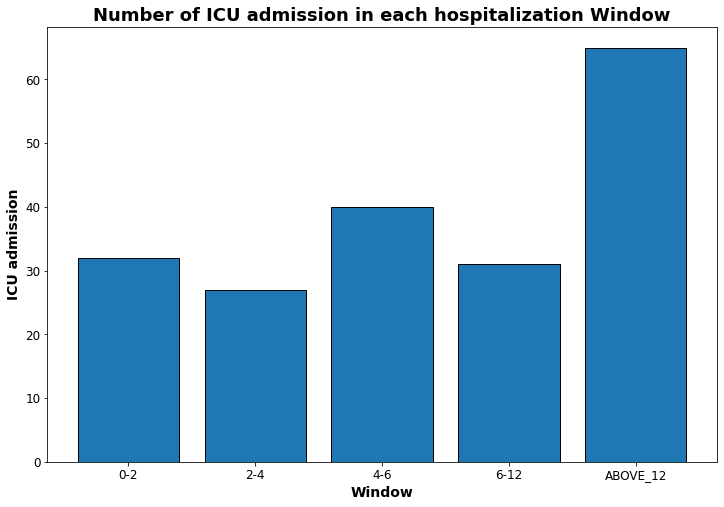

In [ ]:
# ICU admission per window plot
plt.figure(figsize=(12,8))

plt.bar(range(len(windows_icu)), windows_icu.values(), 
        align='center', edgecolor='black')

plt.xticks(range(len(windows_icu)), list(windows_icu.keys()), fontsize=12)
plt.yticks(fontsize=12)

plt.title('Number of ICU admission in each hospitalization Window', 
          fontsize=18, fontweight='bold')

plt.xlabel('Window', fontsize=14, fontweight='bold')
plt.ylabel('ICU admission', fontsize=14, fontweight='bold')

plt.show()

In [ ]:
print('Percentage of ICU admission per Window:' 
      f'\n 0-2: {window_0_2/195*100:.2f}%' 
      f'\n 2-4: {(window_2_4 - window_0_2)/195*100:.2f}%'
      f'\n 4-6: {(window_4_6 - window_2_4)/195*100:.2f}%'
      f'\n 6-12: {(window_6_12 - window_4_6)/195*100:.2f}%' 
      f'\n Above 12: {(window_above12 - window_6_12)/195*100:.2f}%')

Percentage of ICU admission per Window:
 0-2: 16.41%
 2-4: 13.85%
 4-6: 20.51%
 6-12: 15.90%
 Above 12: 33.33%


Looking at the graph above and the percentage of ICU admissions per window, it is possible to conclude that a significant part of ICU admissions occurs in the last window (above 12).

This is an important piece of information, as it can give more time to transfer the patient to another hospital, if necessary, based on the evolution of the case in the other time windows.

## Demographic Information

The dataset has 3 demographic informations, which are:
1. Age above 65 years (0 = below 65, 1 = above 65)
2. Age percentil (10th, 20th, ..., 90th, above 90th)
3. Gender (anonymized into 0 and 1)

### Age Above 65

In [ ]:
age65_vs_icu = create_table_exp_analysis(df_clean, 'AGE_ABOVE65', 'ICU')
age65_vs_icu

,AGE_ABOVE65,ICU,NO_ICU,%ICU,%NO_ICU
0,0,63,128,32.984293,67.015707
1,1,100,61,62.111801,37.888199


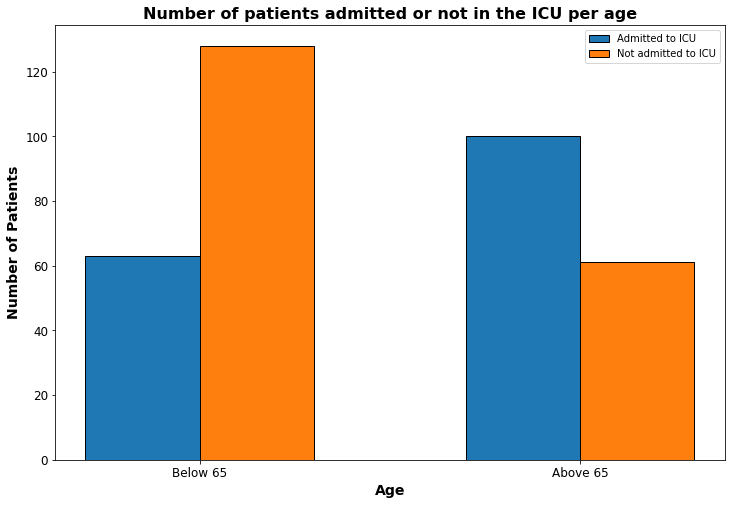

In [ ]:
age = ['Below 65', 'Above 65']

age_icu_plot = create_plot_exp_analysis(2, age65_vs_icu, 
                                       'Number of patients admitted or not in the ICU per age', 
                                       'Age', age)

According to the table and graph above it is clear that patients with age above 65 years have a higher chance be admitted to the ICU, than those with age below 65 years.

### Age Percentil

In [ ]:
age_percentil_vs_icu = create_table_exp_analysis(df_clean, 'AGE_PERCENTIL', 'ICU')
age_percentil_vs_icu

,AGE_PERCENTIL,ICU,NO_ICU,%ICU,%NO_ICU
0,0,7,30,18.918919,81.081081
1,1,11,31,26.190476,73.809524
2,2,16,23,41.025641,58.974359
3,3,13,25,34.210526,65.789474
4,4,16,18,47.058824,52.941176
5,5,13,17,43.333333,56.666667
6,6,17,17,50.000000,50.000000
7,7,24,12,66.666667,33.333333
8,8,20,8,71.428571,28.571429
9,9,26,8,76.470588,23.529412


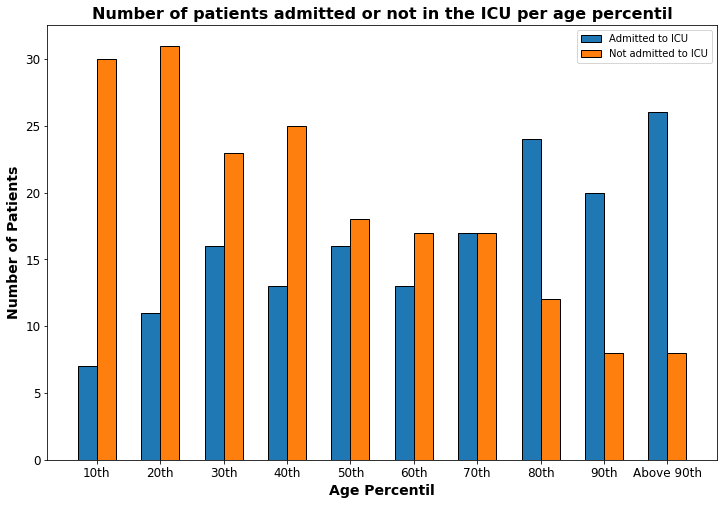

In [ ]:
age_percentil = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th', 'Above 90th']

age_percentil_icu_plot = create_plot_exp_analysis(10, age_percentil_vs_icu,
                                                 'Number of patients admitted or not in the ICU per age percentil',
                                                 'Age Percentil', age_percentil)

Here it is also clear that the older the patient, the higher is the chance of being admitted to the ICU. This result was expected as it was widely discussed, since the beginning of the pandemic, that the elderly are more likely to develop severe symptoms.

### Gender

In [ ]:
gender_vs_icu = create_table_exp_analysis(df_clean, 'GENDER', 'ICU')
gender_vs_icu

,GENDER,ICU,NO_ICU,%ICU,%NO_ICU
0,0,111,107,50.917431,49.082569
1,1,52,82,38.805970,61.194030


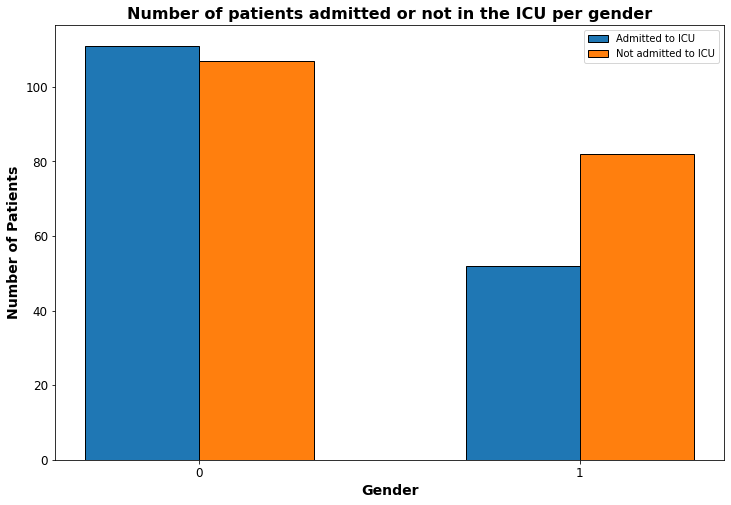

In [ ]:
gender = ['0', '1']

gender_icu_plot = create_plot_exp_analysis(2, gender_vs_icu, 
                                          'Number of patients admitted or not in the ICU per gender',
                                          'Gender', gender)

Looking at the gender, it is possible to notice that the gender "0" is more likely to be admitted to the ICU than the gender "1".
Therefore, we can assume that the gender "0" represents males, while gender "1" is female. 

According to Mukherjee and Pahan (2021), several reports indicate gender differences in COVID-19 cases, with the male gender showing higher severity and fatality rates. These differences can be due to higher levels of angiotensin-converting enzyme 2 (ACE2) receptor and the transmembrane protease serine 2 (TMPRSS2) in males, as both are necessary to the successful entry of SARS-CoV-2 into the body. Also, hormonal influences on the immune response and differences in behavior, such as smoke, comorbidities, and less demand for medical care can be associated with the higher COVID-19 cases in males.

<font size=2> **Source:** Mukherjee, S., Pahan, K. Is COVID-19 Gender-sensitive?. J Neuroimmune Pharmacol 16, 38–47 (2021). [DOI](https://doi.org/10.1007/s11481-020-09974-z)

## Group Diseases Information

The patients previous diseases were grouped in 9 categories:
1. Disease Group 1 (0 = no, 1 = yes)
2. Disease Group 2 (0 = no, 1 = yes)
3. Disease Group 3 (0 = no, 1 = yes)
4. Disease Group 4 (0 = no, 1 = yes)
5. Disease Group 5 (0 = no, 1 = yes)
6. Disease Group 6 (0 = no, 1 = yes)
7. HTN (0 = no, 1 = yes)
8. Immunocompromised (0 = no, 1 = yes)
9. Other Diseases (0 = no, 1 = yes)





### Disease Group 1

In [ ]:
group1_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 1', 'ICU')
group1_vs_icu

,DISEASE GROUPING 1,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,142,173,45.079365,54.920635
1,1.0,21,16,56.756757,43.243243


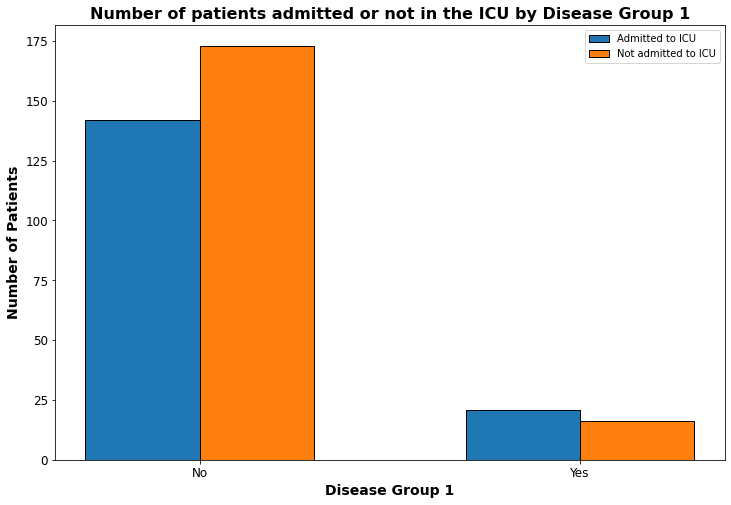

In [ ]:
group1 = ['No', 'Yes']

group1_icu_plot = create_plot_exp_analysis(2, group1_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 1',
                                          'Disease Group 1', group1)

Of the 352 patients hospitalized, 37 had the disease group 1. As we can see in the table above, this group of disease slightly increase the chance of the patient being admitted to the ICU compared to those that don't have this disease group.

### Disease Group 2

In [ ]:
group2_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 2', 'ICU')
group2_vs_icu

,DISEASE GROUPING 2,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,157,187,45.639535,54.360465
1,1.0,6,2,75.000000,25.000000


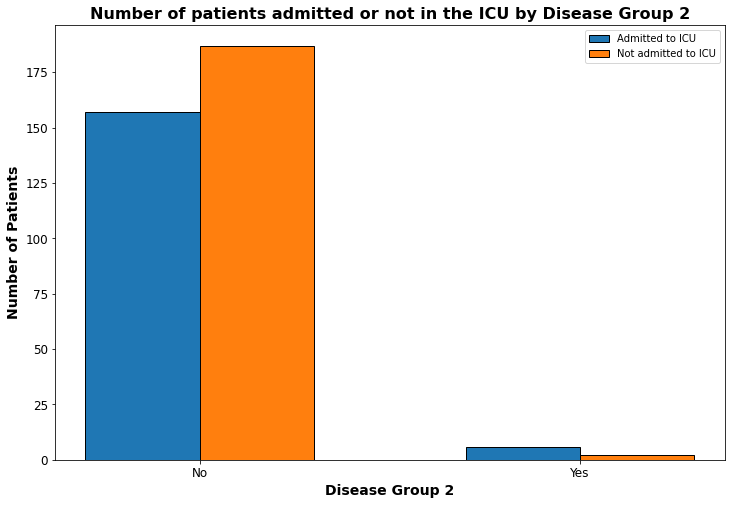

In [ ]:
group2 = ['No', 'Yes']

group2_icu_plot = create_plot_exp_analysis(2, group2_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 2',
                                          'Disease Group 2', group2)

Despite only 8 patients had the disease group 2, 75% of these patients were admitted to the ICU. This indicates that disease group 2 has a high chance to aggravated the patient's condition during the hospitalization.

### Disease Group 3

In [ ]:
group3_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 3', 'ICU')
group3_vs_icu

,DISEASE GROUPING 3,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,142,178,44.375,55.625
1,1.0,21,11,65.625,34.375


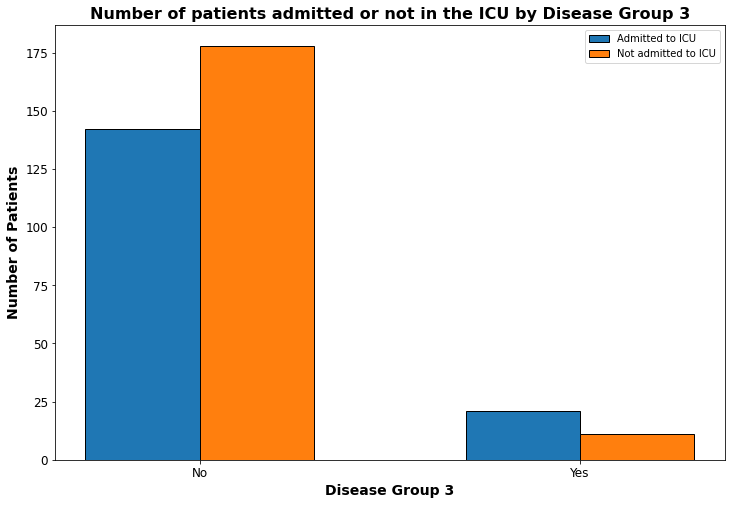

In [ ]:
group3 = ['No', 'Yes']

group3_icu_plot = create_plot_exp_analysis(2, group3_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 3',
                                          'Disease Group 3', group3)

Thirty-three patients were in the disease group 3 (about 10% of the total). Observing the graph and table above, it is possible to notice that disease group 3 also increases the chance of the patient be admitted to the ICU.

### Disease Group 4

In [ ]:
group4_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 4', 'ICU')
group4_vs_icu

,DISEASE GROUPING 4,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,157,188,45.507246,54.492754
1,1.0,6,1,85.714286,14.285714


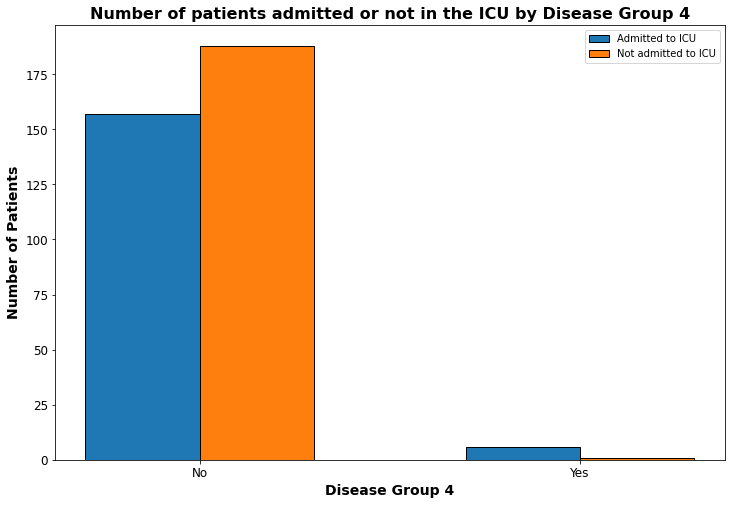

In [ ]:
group4 = ['No', 'Yes']

group4_icu_plot = create_plot_exp_analysis(2, group4_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 4',
                                          'Disease Group 4', group4)

The disease group 4, like group 2, was a condition observed in just a few patients (7), however, it has a really high chance to lead the patient to be admitted to the ICU (85,7%). Therefore, this is a relevant condition to evaluate when the patient is hospitalized with COVID-19 symptoms.

### Disease Group 5

In [ ]:
group5_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 5', 'ICU')
group5_vs_icu

,DISEASE GROUPING 5,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,135,172,43.973941,56.026059
1,1.0,28,17,62.222222,37.777778


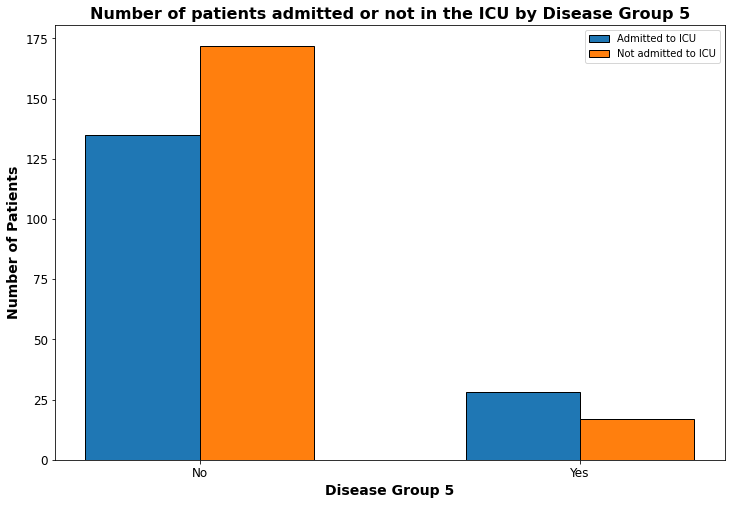

In [ ]:
group5 = ['No', 'Yes']

group5_icu_plot = create_plot_exp_analysis(2, group5_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 5',
                                          'Disease Group 5', group5)

Patients that had the disease group 5 also showed a higher chance to ICU admission, compared to those that don't have the disease.

### Disease Group 6

In [ ]:
group6_vs_icu = create_table_exp_analysis(df_clean, 'DISEASE GROUPING 6', 'ICU')
group6_vs_icu

,DISEASE GROUPING 6,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,157,180,46.587537,53.412463
1,1.0,6,9,40.000000,60.000000


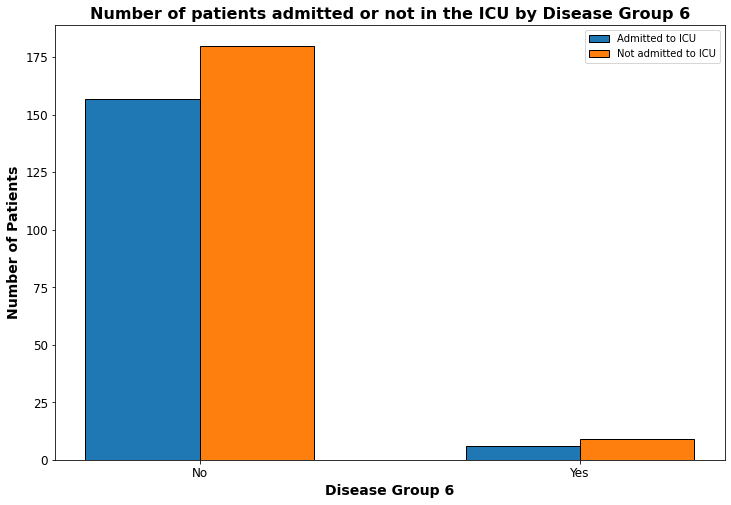

In [ ]:
group6 = ['No', 'Yes']

group6_icu_plot = create_plot_exp_analysis(2, group6_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Disease Group 6',
                                          'Disease Group 6', group6)

Of all the other disease groups evaluated, disease group 6 was the only one that did not show an increase in the chance of the patient being admitted to the ICU. So, it is not a worrisome disease group for the COVID-19 cases.

### Hypertension - HTN

In [ ]:
htn_vs_icu = create_table_exp_analysis(df_clean, 'HTN', 'ICU')
htn_vs_icu

,HTN,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,119,165,41.901408,58.098592
1,1.0,44,24,64.705882,35.294118


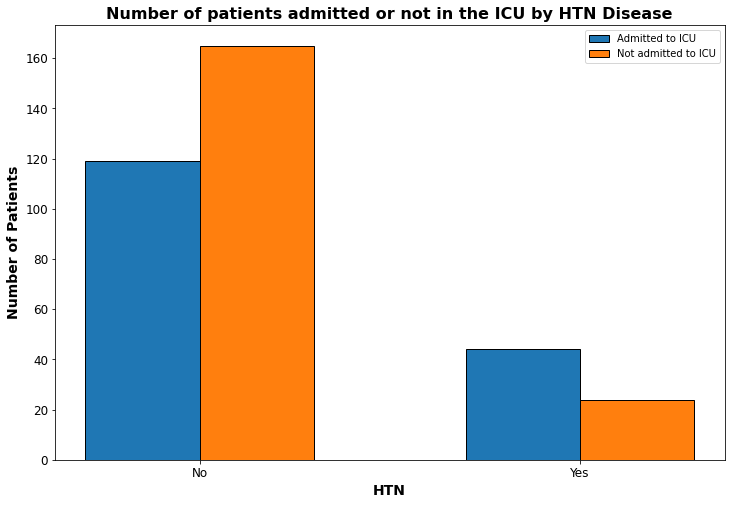

In [ ]:
htn = ['No', 'Yes']

htn_icu_plot = create_plot_exp_analysis(2, htn_vs_icu, 
                                          'Number of patients admitted or not in the ICU by HTN Disease',
                                          'HTN', htn)

Almost 20% (68) of the hospitalized patients have hypertension (high blood pressure). Of those who have hypertension, 64,7% were admitted to the ICU, indicating that hypertension can be related to more severe cases of COVID-19.

According to Schiffrin et al (2020), several reports showed that specific comorbidities can be associated with a higher risk of infection, and among the comorbidities, hypertension is the most common one. Although there is no evidence that hypertension is related to the COVID-19 cases, it is not unexpected that hypertension is common among the patients, since hypertension is very frequent in the elderly, and they seems to be at particular risk of being infected with the SARS-CoV-2 virus and of experiencing severe forms and complications of COVID-19.

In addition, the high prevalence of diabetes and hypertension in severe cases of COVID-19, can be related to the vascular demage caused by these comorbidities, which also increases the chances of death (Yanai, 2020).

<font size=2>**Sources:**

<font size=2>Schiffrin et al (2020). Hypertension and COVID-19. American Journal of Hypertension. 33(5). May, 2020. DOI: [10.1093/ajh/hpaa057](https://doi.org/10.1093/ajh/hpaa057)

<font size=2>Yanai, H (2020). A Significance of High Prevalence of Diabetes and Hypertension in Severe COVID-19 Patients. J Clin Med Res. 12(6): 389–392. Jun, 2020. DOI: [10.14740/jocmr4218](https://doi.org/10.14740/jocmr4218)


### Immunocompromised

In [ ]:
immunocompromised_vs_icu = create_table_exp_analysis(df_clean, 'IMMUNOCOMPROMISED', 'ICU')
immunocompromised_vs_icu

,IMMUNOCOMPROMISED,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,132,163,44.745763,55.254237
1,1.0,31,26,54.385965,45.614035


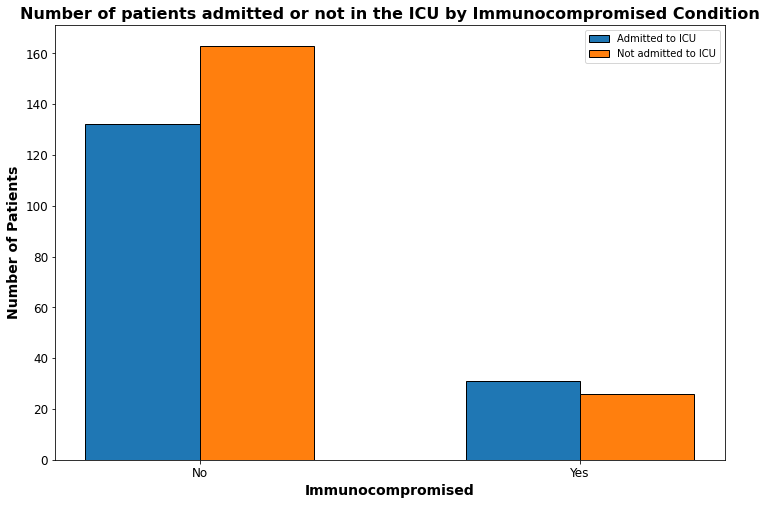

In [ ]:
immunocompromised = ['No', 'Yes']

immunocompromised_icu_plot = create_plot_exp_analysis(2, immunocompromised_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Immunocompromised Condition',
                                          'Immunocompromised', immunocompromised)

There were 57 immunocompromised patients, among those 54,4% were admitted to the ICU. Therefore, the immunocompromised condition did not seem to have a significant impact on increasing the severity of COVID-19 cases.

### Other Diseases

In [ ]:
other_vs_icu = create_table_exp_analysis(df_clean, 'OTHER', 'ICU')
other_vs_icu

,OTHER,ICU,NO_ICU,%ICU,%NO_ICU
0,0.0,24,35,40.677966,59.322034
1,1.0,139,154,47.440273,52.559727


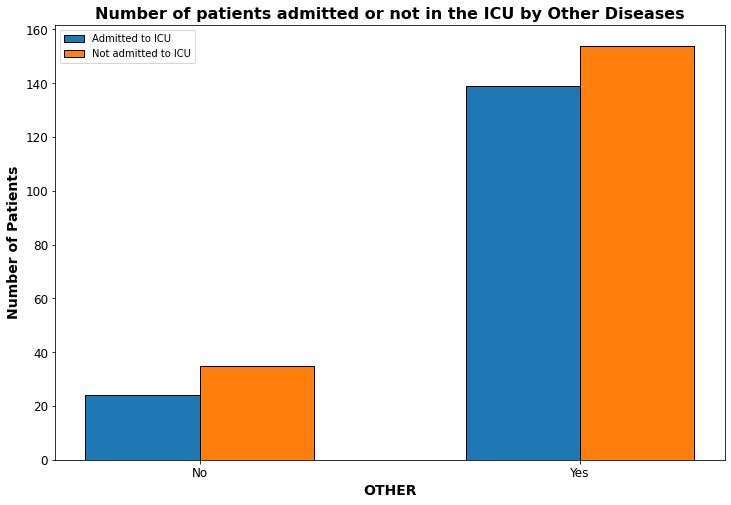

In [ ]:
other = ['No', 'Yes']

other_icu_plot = create_plot_exp_analysis(2, other_vs_icu, 
                                          'Number of patients admitted or not in the ICU by Other Diseases',
                                          'OTHER', other)

Most part of the patients (293) were grouped in "Other Diseases", and this group did not suggest an impact on the ICU admission.

## Pandas Profiling

After analyze the demographic data, I used the pandas profiling to have an overview of the data. As the dataset is quite large, I decided to proceed with the minimal method, which is a simpler and faster analysis.

In [ ]:
#profile = ProfileReport(df_clean, title='ICU Prediction', minimal=True, progress_bar=False, html={'style':{'full_width':True}})

In [ ]:
#profile.to_file(output_file='ICU_Prediction_Report.html')

*P.S.: The Profile Report can be downloaded by removing the # and running the code, including the library at the begining of this notebook, and then clicking on the folder icon on the left side of this notebook (ICU_Prediction_Report.html), and opening the report on your browser.*

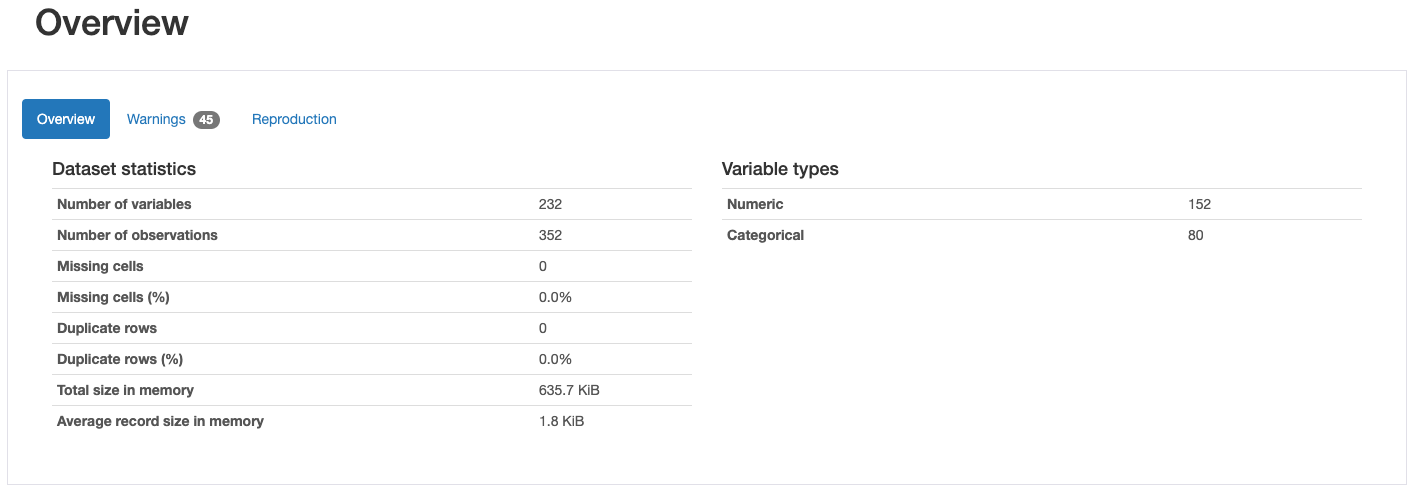

The Pandas Profile Report, using the mininal method, shows an overview of the dataset, an analysis of each variable, and warnings.

In this case, the most important information was the "Warnings", which indicated columns that had constant values, unique values, and percentage of zeros.

# Removing Irrelevant Features

To improve the performance of Machine Learning Models, it is important to select the most relevant data to train the model.

## Constant Values

As seing in the Profile Report, the dataframe has 41 columns with constant values. I considered this data irrelevant for the following analysis and machine learning. So, I chose to remove all these columns.

In [ ]:
# Removing constant columns

df_clean_without_constant = df_clean.loc[:, (df_clean != df_clean.iloc[0]).any()]
df_clean_without_constant

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BLAST_MEDIAN,BLAST_MEAN,BLAST_MIN,BLAST_MAX,CALCIUM_MEDIAN,CALCIUM_MEAN,CALCIUM_MIN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,...,-0.978029,-0.978029,-0.978029,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.00000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,...,-0.978029,-0.978029,-0.978029,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,...,-0.978029,-0.978029,-0.978029,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.317073,-0.935113,-0.935113,-0.935113,-0.935113,-1.0,-1.0,-1.0,-1.0,0.357143,0.357143,0.357143,...,-1.000000,-1.000000,-1.000000,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-0.049383,-0.338462,-0.264151,-0.517241,0.107143,0.736842,0.113402,-0.09375,-0.145299,-0.428571,0.450549,0.898990,-0.341880,-0.535135,-0.417910,-0.575758,-0.101449,0.789474,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-0.31

## High Correlation

If a dataset has highly correlated data there is a high chance that the performance of the model be negatively impacted. This problem is due to multicollinearity, which happens when one predictor variable in a multiple regression model can be linearly predicted from the others with a high degree of accuracy. This can culminate into a biased or misleading results. 

Decision trees and boosted trees algorithms are not affected by multicollinearity, as during the split, the tree will choose only one of the perfectly correlated features. However, other algorithms like Logistic Regression or Linear Regression can be affected by that problem and it should be fixed before training the model.

<font size=2>**Source:** Badr, W. Why feature correlation matters...a lot!. Jan, 2019. [Link](https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4)

So, I removed all columns with data more than 0.95 correlation.

In [ ]:
df_clean_without_corr = remove_high_correlation(df_clean_without_constant, 0.95)
df_clean_without_corr

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,BILLIRUBIN_MEDIAN,BLAST_MEDIAN,CALCIUM_MEDIAN,CREATININ_MEDIAN,FFA_MEDIAN,GGT_MEDIAN,GLUCOSE_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,P02_ARTERIAL_MEDIAN,P02_VENOUS_MEDIAN,PC02_ARTERIAL_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_ARTERIAL_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SAT02_VENOUS_MEDIAN,SODIUM_MEDIAN,TGO_MEDIAN,TGP_MEDIAN,TTPA_MEDIAN,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.170732,-0.704142,-0.77931,-0.754601,-0.859735,0.234043,0.363636,-0.562083,-0.555556,0.345679,-0.085714,-0.995428,-0.987805,-0.846633,-0.869880,-0.978029,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,-0.959849,1.0,-0.382773,-0.908714,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.170732,-0.704142,-0.77931,-0.754601,-0.859735,0.234043,0.363636,-0.562083,-0.555556,0.345679,-0.085714,-0.995428,-0.987805,-0.846633,-0.869880,-0.978029,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,-0.959849,1.0,-0.702202,-0.641079,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
4,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,-0.959849,1.0,-0.706450,-0.340249,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1.000000,-0.049383,-0.338462,-0.264151,-0.525424,0.107143,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,380,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.170732,-0.704142,-0.77931,-0.754601,-0.859735,0.234043,0.363636,-0.562083,-0.555556,0.345679,-0.085714,-0.995428,-0.987805,-0.846633,-0.869880,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
349,381,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.605263,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.905166,-0.742004,-0.958528,-0.891993,-0.069182,-0.959849,1.0,-0.785632,-0.

# Machine Learning Procedures

After cleaning the data, and understand it throughout the exploratory analysis, I started the procedures to select, train, and evaluate the best machine learning model for the current data.

## Model Selection with Pycaret

To proceed with the model selection for my data, I chose to use the Pycaret library, which is easy to set up and very useful for data preparation, model selection and even improving the selected model.

> *PyCaret is an open-source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It is well suited for seasoned data scientists who want to increase the productivity of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding. PyCaret allows you to go from preparing your data to deploying your model within seconds using your choice of notebook environment.*

<font size=2> **Source:** https://pycaret.org/guide/


I used the function *compare_models* to select the 3 best machine learning models that would fit my data.

In [ ]:
#grid = setup(data=df_clean_without_corr, target=df_clean_without_corr.columns[-1],
#             session_id=321, html=False, silent=True, verbose=False)

#best_models = compare_models(n_select=3)
#best_models

*P.S.: This report can be accessed by removing the # and running the code, including the library at the beginning of this notebook*

The results may vary as the algorithm works randomly, differences in numerical precision can occur, as well as changes in the evaluation procedure. 

Therefore, I took a screenshot of the 3 best models and their hyperparameters suggested by the *compare_models* function from Pycaret.

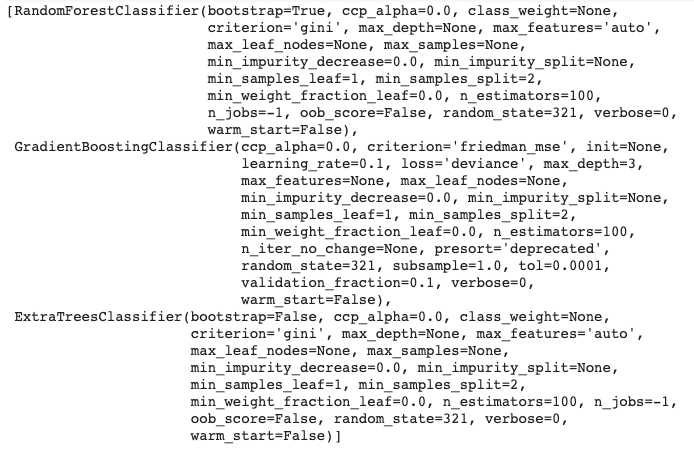

## Evaluating Models

The *compare_models* from Pycaret suggested these three ML models:
- Random Forest Classifier
- Gradient Boosting Classifier
- Extra Trees Classifier

So, the next step is to evaluate each predictive model, and verify which one will fit better for the current data. To evaluate the models, I used the following metrics:
- AUC Score
- Classification Report
- Confusion Matrix



#### **ROC AUC Score**

According to the sklearn documentation, the ROC AUC score is:
> *The Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.*

and, ROC curve is a metric to evaluate classifier output quality by:
> *ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.*


**So, the higher the ROC AUC score, the better is the model in differentiate positive and negative cases.**


<font size=2>**Sources:** 

<font size=2>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

<font size=2>https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html




#### **Classification Report**

The Classification Report builds a text report showing the following classification metrics:

*   Precision is the ability of the classifier not to label as positive a sample that is negative, calculated by:

$$Precision = \frac{True Positive}{True Positive + False Positive}$$

\\

*   Recall is the ability of the classifier to find all the positive samples, calculated by:

$$Recall = \frac{True Positive}{True Positive + False Negative}$$

\\

*   F1-score is a weighted harmonic mean of the precision and recall:

$$F1-score = 2 * \frac{Precision * Recall}{Precision + Recall}$$


<font size=2>**Sources:**

<font size=2>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

<font size=2>https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support


####**Confusion Matrix**

The Confusion Matrix is a specific table layout that allows visualization of the accuracy of an algorithm. The "plot_confusion_matrix" is used to create a figure where each row corresponds to the true class, and each column represents the predicted class. Therefore, it reports the number of true positives, true negatives, false positives, and false negatives predicted by the algorithm.

<font size=2>**Sources:**

<font size=2> https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

<font size=2> https://en.wikipedia.org/wiki/Confusion_matrix

### Random Forest Classifier

The Random Forest Classifier is a supervised machine learning algorithm, which basically creates several decision trees, makes the prediction, and selects the best result using means of voting.

> *A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.*

<font size=2> **Sources:** 

<font size=2> https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<font size=2> https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [ ]:
random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                       criterion='gini', max_depth=None, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=100,
                                       n_jobs=-1, oob_score=False, random_state=321, verbose=0,
                                       warm_start=False)

# Run the model and calculate the AUC score
auc_rf = run_model_auc_score(random_forest, df_clean_without_corr, 5, 10)

 AUC: 0.7335
 Confidence Interval: 0.6431 - 0.8239


              precision    recall  f1-score   support

           0       0.63      0.70      0.67        47
           1       0.61      0.54      0.57        41

    accuracy                           0.62        88
   macro avg       0.62      0.62      0.62        88
weighted avg       0.62      0.62      0.62        88



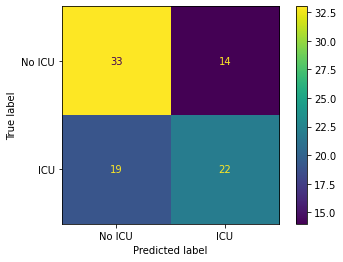

In [ ]:
report_rf, matrix_rf = validation_metrics(df_clean_without_corr, random_forest)

The Random Forest model showed a good ROC AUC score. However, evaluating the classification report and the confusion matrix, it is possible to notice that the model did not perform so well. From the confusion matrix, we can observe that the model had 19 false negatives, which means that the model was not able to predict 46% of the ICU admission.

### Gradient Boosting Classifier

Gradient Boosting (GB) is a class of ensemble machine learning algorithms, and as the name says, the GB Classifier is a classification algorithm.

> *GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.*

<font size=2>**Source:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

In [ ]:
gradient_boosting = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                                               learning_rate=0.1, loss='deviance', max_depth=3,
                                               max_features=None, max_leaf_nodes=None,
                                               min_impurity_decrease=0.0, min_impurity_split=None,
                                               min_samples_leaf=1, min_samples_split=2,
                                               min_weight_fraction_leaf=0.0, n_estimators=100,
                                               n_iter_no_change=None, presort='deprecated',
                                               random_state=321, subsample=1.0, tol=0.0001,
                                               validation_fraction=0.1, verbose=0,
                                               warm_start=False)

auc_gb = run_model_auc_score(gradient_boosting, df_clean_without_corr, 5, 10)

 AUC: 0.7302
 Confidence Interval: 0.6432 - 0.8173


              precision    recall  f1-score   support

           0       0.67      0.74      0.71        47
           1       0.67      0.59      0.62        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88



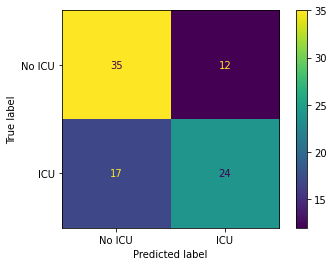

In [ ]:
report_gb, matrix_gb = validation_metrics(df_clean_without_corr, gradient_boosting)

The Gradient Boosting Classifier also showed a good ROC AUC score. In addition, compared to the Random Forest model, Gradient Boosting presented higher values in the classification report. The confusion matrix showed fewer false negatives and false positives, but this model still has a great chance of erroneously predicting ICU admission, as we can see the model failed to predict ICU admission of 17 of the 41 patients who went to the ICU.

### Extra Trees Classifier

Extra Trees Classifier is also a class of ensemble machine learning algorithms. This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

> *In extremely randomized trees (extra-trees), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.*

<font size=2>**Sources:**

<font size=2>https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

<font size=2>https://scikit-learn.org/stable/modules/ensemble.html#forest




In [ ]:
extra_trees = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                                   criterion='gini', max_depth=None, max_features='auto',
                                   max_leaf_nodes=None, max_samples=None,
                                   min_impurity_decrease=0.0, min_impurity_split=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                                   oob_score=False, random_state=321, verbose=0,
                                   warm_start=False)

auc_et = run_model_auc_score(extra_trees, df_clean_without_corr, 5, 10)

 AUC: 0.7099
 Confidence Interval: 0.6074 - 0.8124


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        47
           1       0.66      0.66      0.66        41

    accuracy                           0.68        88
   macro avg       0.68      0.68      0.68        88
weighted avg       0.68      0.68      0.68        88



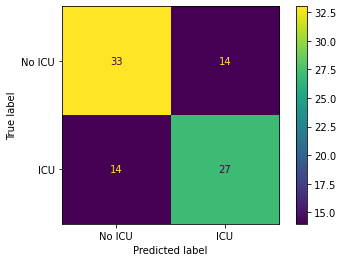

In [ ]:
report_et, matrix_et = validation_metrics(df_clean_without_corr, extra_trees)

The Extra Trees Classifier showed a lower ROC AUC score compared to the two previous models. However, by analyzing the classification report and the confusion matrix, we can see that this model presented more accurate predictive results. Looking at the confusion matrix, the Extra Trees Classifier had fewer false negatives (14) and false positives (14) than the Random Forest and Gradient Boosting models.

## Feature Selection

Selecting the best features is an important step in improving the performance of the models by reducing overfit, and increasing the accuracy. In the topic "Removing Irrelevant Features" I have already made an initial feature selection, by manually removing all the constant and highly correlated data. Now, I will use an automated feature selection method to choose the best features and apply them in the three models that I have been evaluating. The feature selection method that I chose was the Recursive Feature Elimination (RFE).

#### **Recursive Feature Elimination - RFE**

The RFE is a wrapper method, where the feature selection is done by using a machine learning algorithm to fit a subset of features, and select the best one (figure below) for the given dataset.

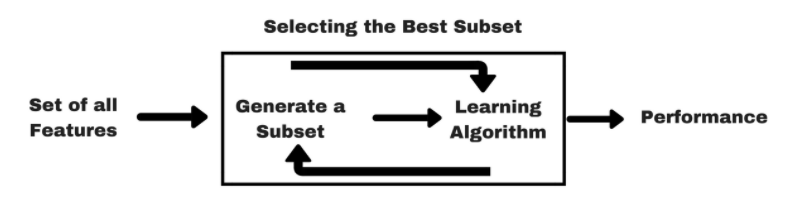

<font size=2>**Figure from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/)** 

> *Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.*

<font size=2>**Source:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html



### Selecting Features

I created a function "rfe_feature_selection_and_new_df" to make the feature selection using RFE and then create a new dataframe using the selected features. The RFE is a wrapper method that uses a machine learning algorithm to make the feature selection. I used "LogisticRegression" as the machine learning method for the RFE.


In [ ]:
df_selected_features = rfe_feature_selection_and_new_df(df_clean_without_corr)
df_selected_features

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 6,HTN,BE_VENOUS_MEDIAN,BIC_ARTERIAL_MEDIAN,BIC_VENOUS_MEDIAN,CALCIUM_MEDIAN,HEMATOCRITE_MEDIAN,INR_MEDIAN,LACTATE_MEDIAN,LEUKOCYTES_MEDIAN,LINFOCITOS_MEDIAN,PC02_VENOUS_MEDIAN,PCR_MEDIAN,PH_VENOUS_MEDIAN,PLATELETS_MEDIAN,POTASSIUM_MEDIAN,SODIUM_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,ICU
0,1,5,0,0.0,0.0,0.0,0.0,1.0,0.0,-1.0,-0.317073,-0.317073,0.357143,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.754601,-0.859735,0.363636,-0.562083,-0.555556,-0.085714,0.086420,0.736842,-1.0,-1.0,1
1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,0.144654,-0.959849,1.0,-0.382773,-0.908714,-0.754601,-0.939887,0.363636,-0.399199,-0.703704,0.085714,-0.049383,0.736842,-1.0,-1.0,1
2,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.754601,-0.859735,0.363636,-0.562083,-0.555556,-0.085714,-0.049383,0.736842,-1.0,-1.0,0
3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,0.358491,-0.959849,1.0,-0.702202,-0.641079,-0.754601,-0.990926,0.363636,-0.457944,-0.592593,0.142857,-0.049383,0.736842,-1.0,-1.0,0
4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,0.291405,-0.959849,1.0,-0.706450,-0.340249,-0.754601,-0.997732,0.363636,-0.292390,-0.666667,0.085714,-0.049383,0.736842,-1.0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.754601,-0.859735,0.363636,-0.562083,-0.555556,-0.085714,-0.160494,0.736842,-1.0,-1.0,1
349,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.754601,-0.859735,0.363636,-0.562083,-0.555556,-0.085714,-0.049383,0.736842,-1.0,-1.0,0
350,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,0.064990,-0.959849,1.0,-0.718038,-0.838174,-0.754601,-0.034405,0.363636,-0.658211,-0.407407,-0.085714,-0.049383,0.736842,-1.0,-1.0,1
351,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.317073,-0.317073,0.357143,-0.069182,-0.959849,1.0,-0.785632,-0.798755,-0.754601,-0.859735,0.363636,-0.562083,-0.555556,-0.085714,-0.049383,0.736842,-1.0,-1.0,0


### Random Forest Classifier

In [ ]:
auc_rf_rfe = run_model_auc_score(random_forest, df_selected_features, 5, 10)

 AUC: 0.7235
 Confidence Interval: 0.6222 - 0.8248


              precision    recall  f1-score   support

           0       0.69      0.70      0.69        47
           1       0.65      0.63      0.64        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88



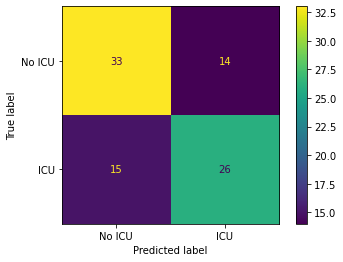

In [ ]:
report_rf_rfe, matrix_rf_rfe = validation_metrics(df_selected_features, random_forest)

Analyzing the Random Forest model, although there was a slight decrease in the ROC AUC score, the model showed an improvement in the precision, recall, and f-1 score from the classification report. Also, the false negatives went from 46% (19) to 36% (15). Thus, the feature selection improved the performance of the Random Forest model.

### Gradient Boosting Classifier

In [ ]:
auc_gb_rfe = run_model_auc_score(gradient_boosting, df_selected_features, 5, 10)

 AUC: 0.7429
 Confidence Interval: 0.6343 - 0.8514


              precision    recall  f1-score   support

           0       0.73      0.70      0.72        47
           1       0.67      0.71      0.69        41

    accuracy                           0.70        88
   macro avg       0.70      0.70      0.70        88
weighted avg       0.71      0.70      0.70        88



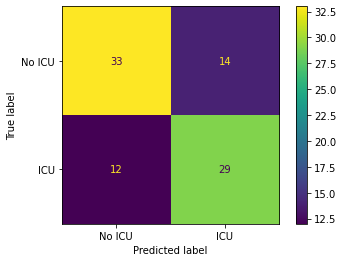

In [ ]:
report_gb_rfe, matrix_gb_rfe = validation_metrics(df_selected_features, gradient_boosting)

In relation to the Gradient Boosting, we can notice an increase in both ROC AUC score and classification report metrics. Analyzing the confusion matrix, there was a significant impact on the false negatives decreasing from 41%(17) to 29%(12). Therefore, the feature selection also had a good improvement on the Gradient Boosting model.

### Extra Trees Classifier

In [ ]:
auc_et_rfe = run_model_auc_score(extra_trees, df_selected_features, 5, 10)

 AUC: 0.7094
 Confidence Interval: 0.6032 - 0.8156


              precision    recall  f1-score   support

           0       0.67      0.70      0.69        47
           1       0.64      0.61      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.66      0.66        88
weighted avg       0.66      0.66      0.66        88



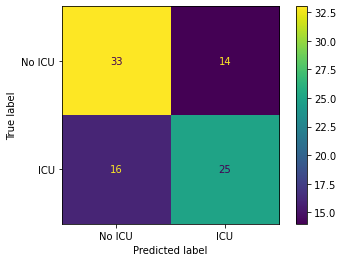

In [ ]:
report_et_rfe, matrix_et_rfe = validation_metrics(df_selected_features, extra_trees)

Unlike the other two models, the Extra Trees had no improvement on the ROC AUC score, in addition, there was a decrease in the classification report metrics, and the confusion matrix showed an increase in the number of false negatives (from 14 to 16). So, in this case, the feature selection did not improve the performance of the model.

# Conclusion

About the exploratory analysis, I could conclude that age, gender, disease group 2 and 4, and hypertension can have an impact in the COVID-19 cases, leading to an increased chance of the patient be admitted to the ICU.

After all the data cleaning, exploratory analysis, model and feature selection, and analyzing the machine learning by validation metrics, the model that best fit into the available data was the Gradient Boosting Classifier. The Gradient Boosting Classifier showed a good ROC AUC score, and improved its classification report and confusion matrix values after the feature selection.

Furthermore, I believe that more data is necessary to improve the performance of the model, also other methods can be applied in the data cleaning process to improve the feature selection, and have a more accurated prediction.